In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn.metrics import make_scorer
from IPython.display import display
import gc
import xgboost as xgb
import operator

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Loading the code


In [4]:
# train_users
train_users = pd.read_csv("train_users_2.csv")
target = train_users['country_destination']
train_users = train_users.drop(['country_destination'], axis=1)

# test_users
test_users = pd.read_csv("test_users.csv")

display(train_users.head())
display(test_users.head())

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


Combining both train and test for some exploration

In [5]:
users = pd.concat((train_users, test_users), axis = 0, ignore_index = True)
print("Number of given users are {} and number of given features are {}".format(users.shape[0],users.shape[1]))
display(users.head())

Number of given users are 275547 and number of given features are 15


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


## Data Exploration


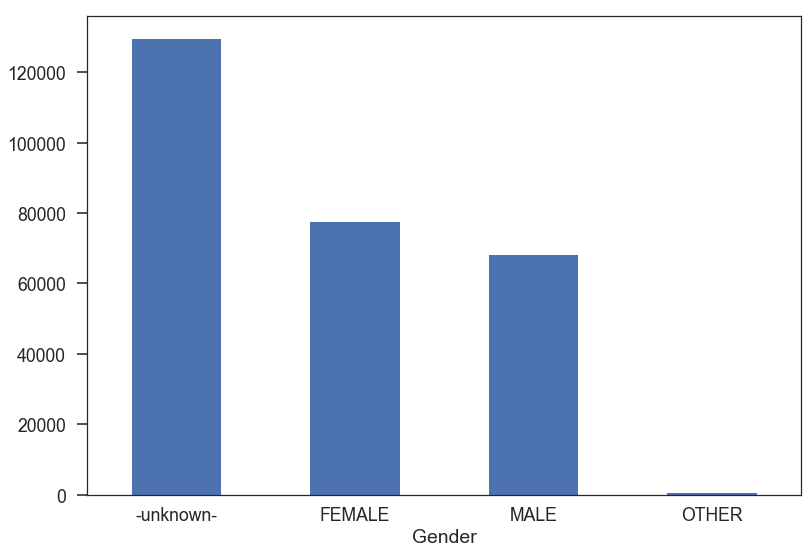

In [6]:
counts = users["gender"].value_counts(dropna=True)
counts.plot(kind="bar",rot=0)
plt.xlabel('Gender')

[<matplotlib.text.Text at 0x11563e748>, <matplotlib.text.Text at 0x116bd2a58>]

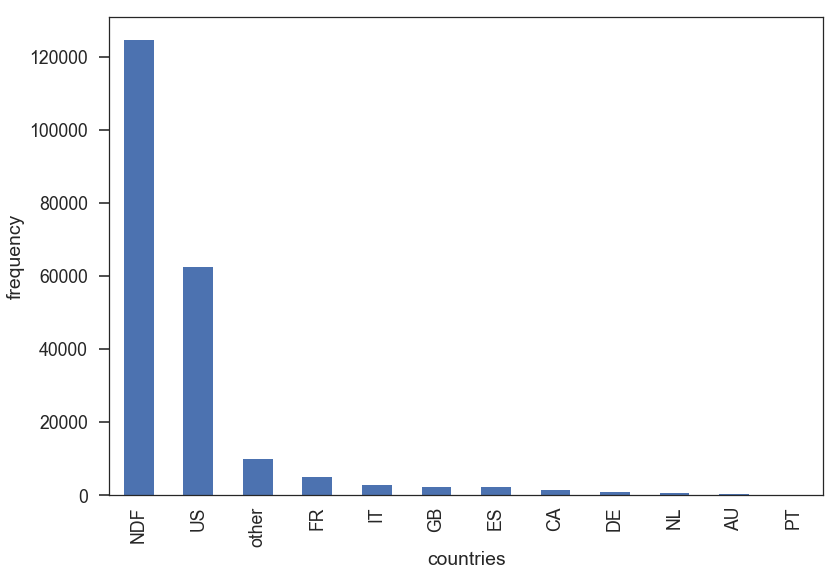

In [7]:
target.value_counts().plot(kind='bar').set(xlabel='countries', ylabel='frequency')

## Data Cleaning

1. Replacing missing data with -1
2. Dropping the "date_first_booking" column
3. Removing erroneous ages

In [8]:
# Calculating % of missing values
display((users.isnull().sum()/users.shape[0])*100)
display((train_users.isnull().sum()/train_users.shape[0])*100)
display((test_users.isnull().sum()/test_users.shape[0])*100)

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         67.733998
gender                      0.000000
age                        42.412365
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.208335
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
dtype: float64

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
dtype: float64

id                           0.000000
date_account_created         0.000000
timestamp_first_active       0.000000
date_first_booking         100.000000
gender                       0.000000
age                         46.502190
signup_method                0.000000
signup_flow                  0.000000
language                     0.000000
affiliate_channel            0.000000
affiliate_provider           0.000000
first_affiliate_tracked      0.032208
signup_app                   0.000000
first_device_type            0.000000
first_browser                0.000000
dtype: float64

In [9]:
users.index = users.id
users = users.fillna(-1)
users = users.replace('-unknown-', -1)

Date of first booking is missing in the test dataset and as it is inconsistent with the training set data, I have decided to drop it.

In [10]:
users = users.drop(['date_first_booking'], axis=1)

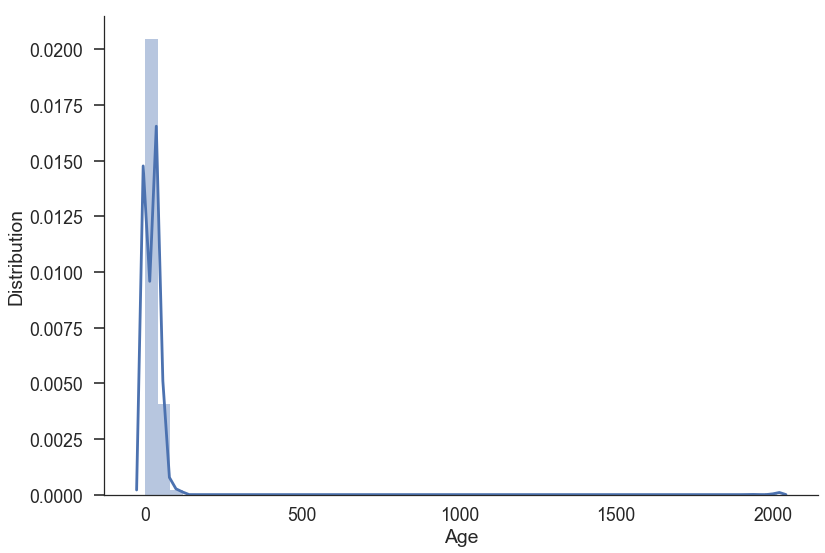

In [11]:
sns.distplot(users.age.dropna())
plt.xlabel('Age')
plt.ylabel('Distribution')
sns.despine()

In [12]:
users.age.loc[users.age < 15] = np.nan
users.age.loc[users.age > 100] = np.nan

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


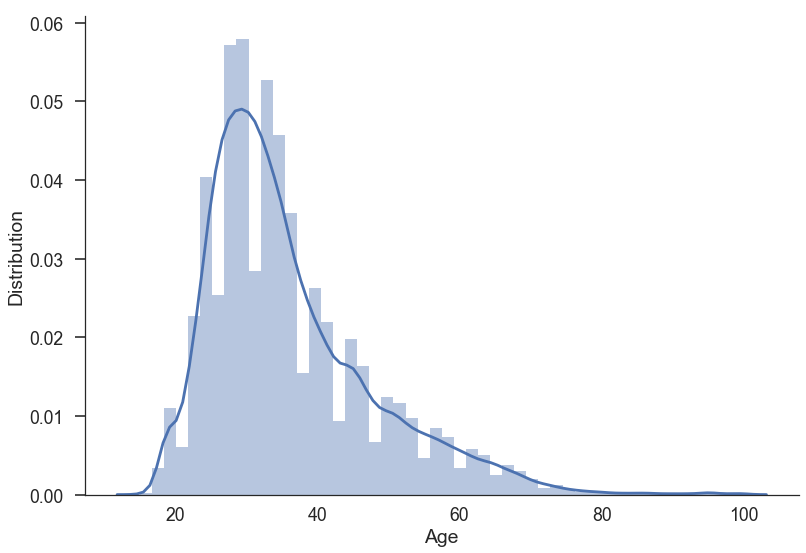

In [13]:
sns.distplot(users.age.dropna())
plt.xlabel('Age')
plt.ylabel('Distribution')
sns.despine()

## Feature Creation

In [14]:
# One-hot encoding the age according the below intervals)
interv =  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100]
def get_interv_value(age):
    iv = 20
    for i in range(len(interv)):
        if age < interv[i]:
            iv = i 
            break
    return iv
users['age_interv'] = users.age.apply(lambda x: get_interv_value(x))
users_ai = pd.get_dummies(users.age_interv, prefix='age_interv')
users = users.drop(['age_interv'], axis=1)
users = pd.concat((users, users_ai), axis=1)

In [15]:
# Splitting the "date_account_created" column into year, data, month, weeknumber and weekday
dac = np.vstack(users.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
users['dac_y'] = dac[:,0]
users['dac_m'] = dac[:,1]
users['dac_d'] = dac[:,2]
dac_dates = [datetime(x[0],x[1],x[2]) for x in dac]
users['dac_wn'] = np.array([d.isocalendar()[1] for d in dac_dates])
users['dac_w'] = np.array([d.weekday() for d in dac_dates])
users_wd = pd.get_dummies(users.dac_w, prefix='dac_w')
users = users.drop(['date_account_created', 'dac_w'], axis=1)
users = pd.concat((users, users_wd), axis=1)

In [16]:
# Splitting the "timestamp_first_active " column into year, data, month, hour, weeknumber and weekday
tfa = np.vstack(users.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
users['tfa_y'] = tfa[:,0]
users['tfa_m'] = tfa[:,1]
users['tfa_d'] = tfa[:,2]
users['tfa_h'] = tfa[:,3]
tfa_dates = [datetime(x[0],x[1],x[2],x[3],x[4],x[5]) for x in tfa]
users['tfa_wn'] = np.array([d.isocalendar()[1] for d in tfa_dates])
users['tfa_w'] = np.array([d.weekday() for d in tfa_dates])
users_wd = pd.get_dummies(users.tfa_w, prefix='tfa_w')
users = users.drop(['timestamp_first_active', 'tfa_w'], axis=1)
users = pd.concat((users, users_wd), axis=1)

In [17]:
# Calculating season each from "date_account_created" and "timestamp_first_active"

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'
def get_season(dt):
    dt = dt.date()
    dt = dt.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= dt <= end)
users['season_dac'] = np.array([get_season(dt) for dt in dac_dates])
users['season_tfa'] = np.array([get_season(dt) for dt in tfa_dates])

In [18]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    users_dummy = pd.get_dummies(users[f], prefix=f)
    users = users.drop([f], axis=1)
    users = pd.concat((users, users_dummy), axis=1)

In [19]:
# Displaying the dataset after creating new features
display(users.head())
print("Number of given users are {} and number of given features are {}".format(users.shape[0],users.shape[1]))

,id,age,age_interv_4,age_interv_5,age_interv_6,age_interv_7,age_interv_8,age_interv_9,age_interv_10,age_interv_11,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
820tgsjxq7,820tgsjxq7,38.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4ft3gnwmtx,4ft3gnwmtx,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bjjt8pjhuk,bjjt8pjhuk,42.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
87mebub9p4,87mebub9p4,41.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Number of given users are 275547 and number of given features are 198


In [20]:
users = users.drop(['id'], axis=1)
users = users.fillna(-1)

In [21]:
display(users.head())

,age,age_interv_4,age_interv_5,age_interv_6,age_interv_7,age_interv_8,age_interv_9,age_interv_10,age_interv_11,age_interv_12,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,-1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
820tgsjxq7,38.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4ft3gnwmtx,56.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
bjjt8pjhuk,42.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87mebub9p4,41.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Save as
users.to_pickle('newUserBookings_checkpoint1')

In [23]:
# Load from "newUserBookings_checkpoint1"
users = pd.read_pickle('newUserBookings_checkpoint1')

In [24]:
def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    
    Example
    -------
    >>> ground_truth = [0 0 0 0 0 0 0 1 0 0 0 0]
    >>> y_score = [ 0.0017368   0.00538507  0.07079092  0.00823662  0.03216999  0.00871099
                    0.01175533  0.61346039  0.00279277  0.0009836   0.20804779  0.03592973]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [ 0.00265752  0.0074776   0.03245427  0.01112108  0.03771622  0.01119133
                        0.0147063   0.49428478  0.00356924  0.00104084  0.33389187  0.04988896]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.630929
    
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [25]:
def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()

    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

## Modeling
1. Random Forest
2. XGBoost

### Random Forest

In [26]:
# Uncomment to Load from Checkpoint
users = pd.read_pickle('newUserBookings_checkpoint1')

In [27]:
def train_test_split_function(users, target, is_test_train_split):
    
    """Splits the combined data into test and train.
    
    Parameters
    ----------
    users : pd.DataFrame
      one row for each observation, one column for each prediction.
    target : array, shape = [n_samples, 1]
        target labels.
    is_test_train_split : bool
        Signifies whether to use split ratio.
        
    Returns
    -------

    X_train, X_test, y_train, y_test, test_set : pd.DataFrame
    
    """
    
    #Split data back into train and test sets
    vals = users.values
    piv_train = len(target)
    X = vals[:piv_train]
    test_set = vals[piv_train:]

    # Encoding 12 country/destination/target variables
    labels = target.values
    le = LabelEncoder()
    y = le.fit_transform(labels)
    
    if is_test_train_split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        return X_train, X_test, y_train, y_test, test_set, le
    
    return X, y, test_set, le
    
X,y, X_test, le = train_test_split_function(users, target, is_test_train_split = False)

In [28]:
clf = RandomForestClassifier(n_estimators=25, random_state=101)
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 8]
             }

reg = grid_search.GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)

reg.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=101,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 20], 'max_depth': [6, 8]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(ndcg_score, needs_proba=True, k=5), verbose=0)

In [29]:
est = reg.best_estimator_
est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=101,
            verbose=0, warm_start=False)

In [30]:
y_pred = est.predict_proba(X)

def validation_prediction(y_pred, y, le, print_msg):

    truth = pd.Series(le.inverse_transform(y))
    print(print_msg + str(ndcg_score(truth, y_pred)))
    
print_msg =  "Validation Score for Random Forest: "
validation_prediction(y_pred, y, le, print_msg)

Validation Score for Random Forest: 0.817564277726


In [31]:
# Making predictions on the test set
ypred = est.predict_proba(X_test)

def test_prediction(ypred, file_name):
    id_test = test_users['id']
    # Showing top 5 classes with highest probabilities
    ids = []  #list of ids
    cts = []  #list of countries
    for i in range(len(id_test)):
        idx = id_test[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

    sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
    sub.to_csv(file_name,index=False)
file_name = 'random_forest.csv'
test_prediction(ypred, file_name)

### XGBoost


In [32]:
X,y, test_set, le = train_test_split_function(users, target, is_test_train_split=False)

In [33]:
# XGB Classifier Parameters
params = {'eta': 0.2,
          'max_depth': 6,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'objective': 'multi:softprob',
          'num_class': 12}

In [34]:
# First train on whole training set for feature importances
num_boost_round = 1
dtrain = xgb.DMatrix(X, y)
clf1 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

# Get feature scores and store in DataFrame
importance = clf1.get_fscore()
importance_df = pd.DataFrame(
    sorted(importance.items(), key=operator.itemgetter(1)), 
    columns=['feature','fscore']
    )

top_features = [users.columns[int(i.split('f')[1])] for i in importance_df.iloc[-30:,:].feature.values]

display(top_features)

['age_interv_8',
 'affiliate_channel_content',
 'age_interv_11',
 'affiliate_channel_sem-brand',
 'first_browser_-1',
 'signup_method_facebook',
 'dac_w_6',
 'signup_flow_0',
 'gender_MALE',
 'signup_flow_1',
 'first_browser_Chrome',
 'affiliate_channel_direct',
 'first_device_type_Windows Desktop',
 'gender_-1',
 'signup_app_Web',
 'first_device_type_Mac Desktop',
 'first_affiliate_tracked_untracked',
 'season_dac',
 'gender_FEMALE',
 'first_affiliate_tracked_-1',
 'dac_m',
 'dac_y',
 'tfa_y',
 'signup_flow_3',
 'tfa_wn',
 'tfa_d',
 'dac_wn',
 'age',
 'tfa_h',
 'dac_d']

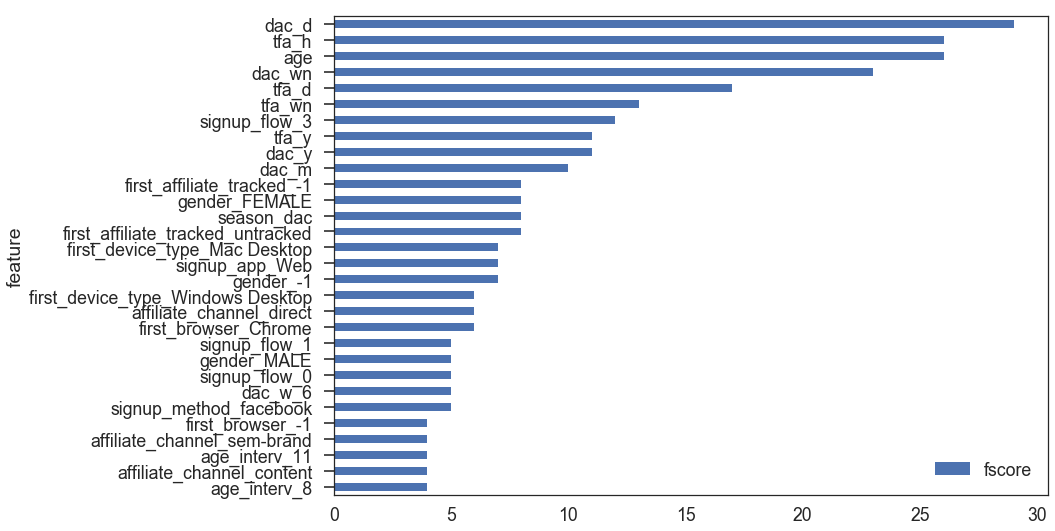

In [35]:
importance_df.feature = [users.columns[int(i.split('f')[1])] for i in importance_df.feature.values]
# Plot feature importance of top 30
importance_df.iloc[-30:,:].plot(x='feature',y='fscore',kind='barh')

### Utilizing Top Features for modeling

In [36]:
users_clf2 = users[top_features]
X_train, X_test, y_train, y_test, test_set, le = train_test_split_function(users_clf2, target, is_test_train_split = True)

In [37]:
# Train the XGB Classifier
dtrain = xgb.DMatrix(X_train, y_train)
clf2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

In [39]:
# Predicting on Validation Set

y_pred = clf2.predict(xgb.DMatrix(X_test))
print_msg = "Validation Score for XGBoost using top 30 features: "
validation_prediction(y_pred, y_test, le, print_msg)

Validation Score for XGBoost using top 30 features: 0.813677612442


In [40]:
# Predicting on test set
y_pred = clf2.predict(xgb.DMatrix(test_set))
file_name = 'xgb_feature_importance.csv'
test_prediction(ypred, file_name)

### XGBoost Hyperparameter Tuning

In [41]:
from xgboost.sklearn import XGBClassifier

clf_rp = XGBClassifier(
        max_depth=7,
        learning_rate=0.18,
        n_estimators=80,
        objective="rank:pairwise",
        gamma=0,
        min_child_weight=1,
        max_delta_step=0,
        subsample=1,
        colsample_bytree=1,
        colsample_bylevel=1,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        base_score=0.5,
        missing=None,
        silent=True,
        nthread=-1,
        seed=111
    )

In [42]:
# Train the XGB Classifier with objective function as Rank pairwise. 
# This makes the model to predict the relative score for each document to a specific query,  
# instead of classifying the classes
users_clf2_rp = users[top_features]
X_train, X_test, y_train, y_test, test_set, le = train_test_split_function(users_clf2_rp, target, is_test_train_split = True)

clf_rp.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.18, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=1, nthread=-1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=111,
       silent=True, subsample=1)

In [43]:
# Predicting on Validation Set
y_pred_rp = clf_rp.predict_proba(X_test)

print_msg = "Validation Score for XGBoost(RankPairwise) using top 30 features: "
validation_prediction(y_pred_rp, y_test, le, print_msg)

Validation Score for XGBoost(RankPairwise) using top 30 features: 0.823843007379


In [44]:
# Predicting on test set
y_pred = clf_rp.predict_proba(test_set)
file_name = 'xgb_hyperPtuned_rp.csv'
test_prediction(ypred, file_name)

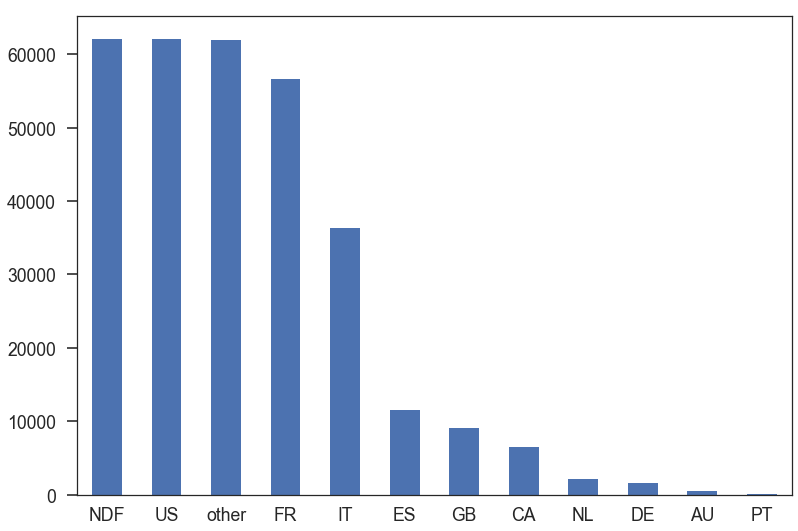

In [45]:
# Plotting the predicted countries count
results = pd.read_csv("xgb_hyperPtuned_rp.csv")
results["country"].value_counts().plot(kind="bar",rot=0)